In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from torch import tensor
from torchmetrics.classification import BinaryAUROC, BinaryROC, BinaryF1Score, BinaryAccuracy, BinaryPrecision, BinaryRecall


In [107]:
image_path_train = "marble/train/good"
image_path_ok = "marble/test/good"

In [108]:
BATCH_SIZE = 16
N_EPOCHS = 10
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is {DEVICE}.")

The device is cpu.


In [109]:
import math


class ConvAutoencoder(nn.Module):
    def __init__(self, input_size=128, img_channels=3, latent_space=256):
        super(ConvAutoencoder, self).__init__()

        assert math.log2(input_size).is_integer(), "Input size must be a power of 2 (e.g., 64, 128, 256)"
        self.input_size = input_size

        # Build encoder dynamically
        layers = []
        channels = [img_channels, 16, 32, 64, 128]
        size = input_size
        for i in range(len(channels) - 1):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=4, stride=2, padding=1))
            layers.append(nn.ReLU(True))
            size //= 2  # downsampling step

        self.encoder_conv = nn.Sequential(*layers)
        self.flattened_size = channels[-1] * size * size
        self.encoder_fc = nn.Linear(self.flattened_size, latent_space)

        # Decoder
        self.decoder_fc = nn.Linear(latent_space, self.flattened_size)

        # Build decoder (inverse of encoder)
        decoder_layers = []
        channels = list(reversed(channels))
        for i in range(len(channels) - 1):
            decoder_layers.append(nn.ConvTranspose2d(
                channels[i], channels[i+1], kernel_size=4, stride=2, padding=1))
            if i < len(channels) - 2:
                decoder_layers.append(nn.ReLU(True))
            else:
                decoder_layers.append(nn.Tanh())  # final layer

        self.decoder_conv = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        z = self.encoder_fc(x)

        x = self.decoder_fc(z)
        x = x.view(x.size(0), -1, self.input_size // (2 ** 4), self.input_size // (2 ** 4))  # 4 conv layers
        x = self.decoder_conv(x)
        return x


In [110]:
IMAGE_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [111]:
class MarbleImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None, val=False):
        self.img_dir = img_dir
        self.image_names = os.listdir(self.img_dir)
        val_len = int(len(self.image_names) * 0.2)
        if val:
            # last 20% are validation images
            self.image_names = self.image_names[-val_len:]
        else:
            # everything before last 20% are training images
            self.image_names = self.image_names[:-val_len]
            
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_names[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [112]:
train_dataset = MarbleImageDataset(image_path_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [113]:
val_dataset = MarbleImageDataset(image_path_train, transform=transform, val=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [114]:
import json
from tqdm import tqdm

# model = Autoencoder().to(DEVICE)
model = ConvAutoencoder(input_size=IMAGE_SIZE).to(DEVICE)
criterion = nn.MSELoss()
if (
    os.path.exists("model.pth")
    and os.path.exists("losses.json")
    and os.path.exists("batch_losses.json")
):
    model.load_state_dict(torch.load("model.pth", weights_only=True))
    losses = json.load(open("losses.json", encoding="utf-8"))
    batch_losses = json.load(open("batch_losses.json", encoding="utf-8"))
else:
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    losses = []
    batch_losses = []

    for epoch in range(N_EPOCHS):
        model.train()
        total_loss = 0
        for imgs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}"):
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, imgs)
            val_losses = []
            for val_imgs in tqdm(val_loader, desc="Validating"):
                val_imgs = val_imgs.to(DEVICE)
                val_outputs = model(val_imgs)
                val_loss = criterion(val_outputs, val_imgs)
                val_losses.append(val_loss.detach())
            val_loss = np.mean(val_losses)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_losses.append({"Batch Loss": loss.item(), "Validation Loss": val_loss.item()})

        mean_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{N_EPOCHS}], Loss: {mean_loss:.6f}")
        losses.append(mean_loss)

    json.dump(losses, open("losses.json", "w", encoding="utf-8"))
    json.dump(batch_losses, open("batch_losses.json", "w", encoding="utf-8"))
    torch.save(model.state_dict(), "model.pth")

In [115]:
import pandas as pd
import plotly.express as px

df_losses = pd.DataFrame(batch_losses)
df_losses

,Batch Loss,Validation Loss
0,0.154323,0.162668
1,0.104166,0.162146
2,0.157522,0.159341
3,0.160672,0.156663
4,0.127131,0.152387
...,...,...
425,0.001263,0.001830
426,0.001727,0.001842
427,0.001890,0.001880
428,0.001118,0.001820


In [116]:
fig = px.line(df_losses, labels={"value": "MSE Loss", "index": "Batch Number"})
fig.update_layout(
    width=800,
    height=400,
    legend=None,
    margin=dict(l=20, r=20, t=20, b=20),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)
fig.write_image("../images/batch_loss.pdf")
fig.write_image("../images/batch_loss.png")
fig.show()

In [117]:
def compare_orig_and_reconstructed(orig, recon, error, path=None):
    # Revert normalization
    orig = (orig + 1) / 2
    recon = (recon + 1) / 2
    diff = abs(recon - orig)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(np.transpose(orig[0], (1, 2, 0)))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Reconstructed ({error:.4f})")
    plt.imshow(np.transpose(recon[0], (1, 2, 0)))
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Difference")
    plt.imshow(np.transpose(diff[0], (1, 2, 0)))
    plt.axis("off")

    if path is not None:
        plt.savefig(path, dpi=199, bbox_inches="tight")
    plt.show()

In [118]:
def compute_reconstruction_error_from_path(img_path):
    img = Image.open(img_path)
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(img_tensor)
    loss = criterion(output, img_tensor).item()
    return loss, img_tensor.cpu(), output.cpu()

In [119]:
import torch.nn.functional as F

def compute_reconstruction_error(original, reconstructed):
    # Mean squared error per sample
    errors = F.mse_loss(reconstructed, original, reduction='none')
    errors = errors.view(errors.size(0), -1).mean(dim=1)  # (B,)
    return errors

In [120]:
# Run model on validation set
model.eval()
all_errors = []
with torch.no_grad():
    for batch in val_loader:
        imgs = batch.to(DEVICE)
        recon = model(imgs)
        errors = compute_reconstruction_error(imgs, recon)
        all_errors.extend(errors.cpu().numpy())

# Set threshold to 95th percentile of normal reconstruction error
import numpy as np
threshold_50_q = np.percentile(all_errors, 50)
threshold_80_q = np.percentile(all_errors, 80)
threshold_90_q = np.percentile(all_errors, 90)
threshold_95_q = np.percentile(all_errors, 95)
threshold_99_q = np.percentile(all_errors, 99)
threshold_max = np.max(all_errors)
threshold_50_q, threshold_80_q, threshold_90_q, threshold_95_q, threshold_99_q, threshold_max

(np.float32(0.0012105682),
 np.float32(0.002319264),
 np.float32(0.0034521199),
 np.float32(0.006526873),
 np.float32(0.009125256),
 np.float32(0.009750993))

In [121]:
d_50_q = np.percentile(all_errors, 50)
threshold_80_q = np.percentile(all_errors, 80)
threshold_90_q = np.percentile(all_errors, 90)
threshold_95_q = np.percentile(all_errors, 95)
threshold_99_q = np.percentile(all_errors, 99)
threshold_max = np.max(all_errors)
threshold_80_q, threshold_90_q, threshold_95_q, threshold_99_q, threshold_max

(np.float32(0.002319264),
 np.float32(0.0034521199),
 np.float32(0.006526873),
 np.float32(0.009125256),
 np.float32(0.009750993))

Reconstruction error: 0.0016


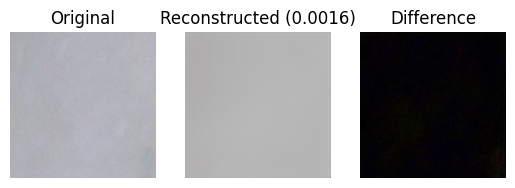

Reconstruction error: 0.0524


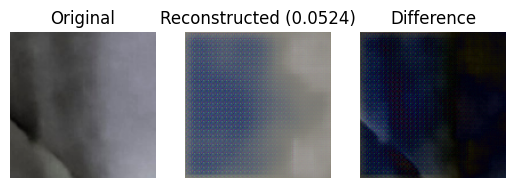

Reconstruction error: 0.0072


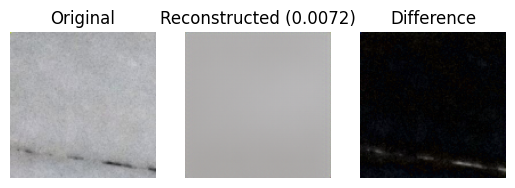

Reconstruction error: 0.0022


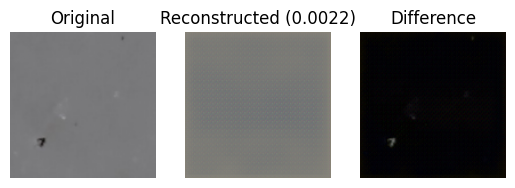

In [122]:
# Example
error, orig, recon = compute_reconstruction_error_from_path("marble/test/good/_0_0_20210525_15434.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_good.png")

error, orig, recon = compute_reconstruction_error_from_path("marble/test/crack/_0_0_20210531_17292_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_crack.png")

error, orig, recon = compute_reconstruction_error_from_path("marble/test/joint/_0_4352_20210525_15441_1.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_joint.png")

error, orig, recon = compute_reconstruction_error_from_path("marble/test/dot/_0_2560_20210531_10521_0.jpg")
print(f"Reconstruction error: {error:.4f}")
compare_orig_and_reconstructed(orig, recon, error, "../images/rec_dot.png")

In [123]:
from numpy import mean


def compute_reconstruction_errors(directory, error_thresh = None):
    recon_errors = []
    for file_name in os.listdir(directory):
        error, orig, recon = compute_reconstruction_error_from_path(os.path.join(directory, file_name))
        if error_thresh is not None:
            if error > error_thresh:
                print(error)
                compare_orig_and_reconstructed(orig, recon)
        recon_errors.append(error)
    return recon_errors

In [124]:
recon_errors_good = compute_reconstruction_errors("marble/test/good")
print(np.mean(recon_errors_good))
recon_errors_crack = compute_reconstruction_errors("marble/test/crack")
print(np.mean(recon_errors_crack))
recon_errors_joint = compute_reconstruction_errors("marble/test/joint")
print(np.mean(recon_errors_joint))
recon_errors_dot = compute_reconstruction_errors("marble/test/dot")
print(np.mean(recon_errors_dot))

0.0017863473040907753
0.02439584803121559
0.014388651723581631
0.008098905288628383


In [125]:
recon_errors_good_list_of_dicts = [{"class": "Gut", "error": error} for error in recon_errors_good]
recon_errors_crack_list_of_dicts = [{"class": "Riss", "error": error} for error in recon_errors_crack]
recon_errors_joint_list_of_dicts = [{"class": "Verbindung", "error": error} for error in recon_errors_joint]
recon_errors_dot_list_of_dicts = [{"class": "Punkt", "error": error} for error in recon_errors_dot]
all_recon_errors = (
    recon_errors_good_list_of_dicts
    + recon_errors_crack_list_of_dicts
    + recon_errors_joint_list_of_dicts
    + recon_errors_dot_list_of_dicts
)
all_recon_errors_df = pd.DataFrame(all_recon_errors)
all_recon_errors_df

,class,error
0,Gut,0.001019
1,Gut,0.000893
2,Gut,0.000786
3,Gut,0.002006
4,Gut,0.001796
...,...,...
1130,Punkt,0.009703
1131,Punkt,0.001964
1132,Punkt,0.003765
1133,Punkt,0.002627


In [126]:
fig = px.box(
    all_recon_errors_df,
    x="class",
    color="class",
    y="error",
    width=800,
    height=500,
    # title="Rekonstruktionsfehler für verschiedene Klassen",
)

median_errors = all_recon_errors_df.groupby("class")["error"].median().reset_index()
# Add annotations for each class
for i, row in median_errors.iterrows():
    fig.add_annotation(
        x=row["class"],
        y=row["error"],
        text=f"Median: {row['error']:.4f}",
        showarrow=False,
        yshift=10,
        font=dict(size=12, color="black"),
    )

fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    title=dict(font=dict(size=30)),
    yaxis=dict(title="Rekonstruktionsfehler", tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(title="Klasse", tickfont=dict(size=15), title_font=dict(size=20)),
)
fig.show()
fig.write_image("../images/box_plot_recon_errors.pdf")
fig.write_image("../images/box_plot_recon_errors.png")

In [127]:
def is_anomaly(original, reconstructed, threshold):
    errors = compute_reconstruction_error(original, reconstructed).cpu().numpy()
    return errors > threshold  # Boolean tensor

In [128]:
results = {
    "good": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "crack": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "joint": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
    "dot": {"tp": 0, "tn": 0, "fp": 0, "fn": 0, "total": 0},
}

for directory, anomaly in [
    ("marble/test/good", False),
    ("marble/test/crack", True),
    ("marble/test/joint", True),
    ("marble/test/dot", True),
]:
    for img_path in os.listdir(directory):
        img = Image.open(os.path.join(directory, img_path))
        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor)
        pred = is_anomaly(img_tensor, output, threshold=threshold_90_q)
        results[directory.split("/")[-1]]["total"] += 1
        if anomaly:
            if pred:
                results[directory.split("/")[-1]]["tp"] += 1
            else:
                results[directory.split("/")[-1]]["fn"] += 1
        else:
            if pred:
                results[directory.split("/")[-1]]["fp"] += 1
            else:
                results[directory.split("/")[-1]]["tn"] += 1

In [129]:
results

{'good': {'tp': 0, 'tn': 310, 'fp': 30, 'fn': 0, 'total': 340},
 'crack': {'tp': 253, 'tn': 0, 'fp': 0, 'fn': 35, 'total': 288},
 'joint': {'tp': 326, 'tn': 0, 'fp': 0, 'fn': 65, 'total': 391},
 'dot': {'tp': 71, 'tn': 0, 'fp': 0, 'fn': 45, 'total': 116}}

In [130]:
conf_df = pd.DataFrame(
    {
        "good": {
            "Anomalie": results["good"]["fp"] / results["good"]["total"],
            "Keine Anomalie": results["good"]["tn"] / results["good"]["total"],
        },
        "crack": {
            "Anomalie": results["crack"]["fn"] / results["crack"]["total"],
            "Keine Anomalie": results["crack"]["tp"] / results["crack"]["total"],
        },
        "joint": {
            "Anomalie": results["joint"]["fn"] / results["joint"]["total"],
            "Keine Anomalie": results["joint"]["tp"] / results["joint"]["total"],
        },
        "dot": {
            "Anomalie": results["dot"]["fn"] / results["dot"]["total"],
            "Keine Anomalie": results["dot"]["tp"] / results["dot"]["total"],
        },
    }
)

In [131]:
import plotly.graph_objects as go

# Data and totals
totals = [340, 288, 391, 116]
raw = [[310, 30], [35, 253], [65, 326], [45, 71]]

# Convert to percentages
z_percent = [
    [round((val / totals[i]) * 100, 2) for val in row] for i, row in enumerate(raw)
]

# Labels
classes = ["Gut", "Riss", "Verbindung", "Punkt"]
predicted = ["Vorhersage Normal", "Vorhersage Anomalie"]

# Annotation text
text = [[f"{v}%" for v in row] for row in z_percent]

# Plot
fig = go.Figure(
    data=go.Heatmap(
        z=z_percent,
        x=predicted,
        y=classes,
        hoverinfo="z",
        colorscale="Blues",
        showscale=True,
        zmin=0,
        zmax=100,
    )
)

# Annotations
for i in range(len(z_percent)):
    for j in range(len(z_percent[0])):
        fig.add_annotation(
            dict(
                text=text[i][j],
                x=predicted[j],
                y=classes[i],
                font=dict(color="black", size=14),
                showarrow=False,
            )
        )

fig.update_layout(
    # title=dict(text="Klassenweise Confusion-Matrix", font=dict(size=30)),
    xaxis_title="Vorhergesagtes Label",
    yaxis_title="Tatsächliche Klasse",
    yaxis_autorange="reversed",
    margin=dict(l=20, r=20, t=20, b=20),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    width=800,
    height=500,
)

fig.show()
fig.write_image("../images/conf-matrix.pdf")
fig.write_image("../images/conf-matrix.png")

# ROC Curve

In [132]:
all_anomaly_scores = {
    "good": [],
    "crack": [],
    "joint": [],
    "dot": [],
}

for directory, anomaly in [
    ("marble/test/good", False),
    ("marble/test/crack", True),
    ("marble/test/joint", True),
    ("marble/test/dot", True),
]:
    for img_path in os.listdir(directory):
        img = Image.open(os.path.join(directory, img_path))
        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(img_tensor)
        anomaly_score = compute_reconstruction_error(img_tensor, output).cpu().numpy().item()
        all_anomaly_scores[directory.split("/")[-1]].append(anomaly_score)

In [133]:
def calculate_precision_recall(good_scores, anomaly_scores, threshold):
    tp = len([sc for sc in anomaly_scores if sc > threshold])
    fn = len(anomaly_scores) - tp
    tn = len([sc for sc in good_scores if sc < threshold])
    fp = len(good_scores) - tn
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall


In [134]:
def calculate_tpr_fpr(good_scores, anomaly_scores, threshold):
    tp = len([sc for sc in anomaly_scores if sc > threshold])
    fn = len(anomaly_scores) - tp
    tn = len([sc for sc in good_scores if sc < threshold])
    fp = len(good_scores) - tn
    
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    return fpr, tpr

In [135]:
good_scores = all_anomaly_scores["good"]
anomaly_scores = all_anomaly_scores["crack"] + all_anomaly_scores["dot"] + all_anomaly_scores["joint"]

percentile_0 = np.percentile(good_scores, 0)
percentile_100 = np.percentile(good_scores, 100)


threshs_precisions_recalls = []
threshs_tprs_fprs = []
for thresh in np.arange(percentile_0, percentile_100, (percentile_100 - percentile_0) / 100):
    precision, recall = calculate_precision_recall(good_scores, anomaly_scores, thresh)
    tpr, fpr = calculate_tpr_fpr(good_scores, anomaly_scores, thresh)
    threshs_precisions_recalls.append({"thresh": thresh, "Precision": precision, "Recall": recall})
    threshs_tprs_fprs.append({"thresh": thresh, "TPR": tpr, "FPR": fpr})


In [136]:
df_precision_recall_curve = pd.DataFrame(threshs_precisions_recalls)
df_precision_recall_curve.head(2)

,thresh,Precision,Recall
0,0.000298,0.700441,1.000000
1,0.000468,0.715315,0.998742


In [137]:
fig = px.line(
    df_precision_recall_curve,
    x="Recall",
    y="Precision",
    width=600,
    height=600,
    # title="Precision Recall Curve",
)
fig.update_layout(
    yaxis_range=[0, 1],
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    title=dict(font=dict(size=30)),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)
fig.write_image("../images/precision_recall_curve.pdf")
fig.write_image("../images/precision_recall_curve.png")
fig.show()

In [138]:
df_roc_curve = pd.DataFrame(threshs_tprs_fprs)
df_roc_curve.head(2)

,thresh,TPR,FPR
0,0.000298,1.000000,1.000000
1,0.000468,0.929412,0.998742


In [139]:
preds = tensor(good_scores + anomaly_scores)
target = tensor([0] * len(good_scores) + [1] * len(anomaly_scores))
metric = BinaryAUROC(thresholds=None)
auc = metric(preds, target)
auc

tensor(0.9311)

In [140]:
roc = BinaryROC(thresholds=1000)
rocs = roc(preds, target)
fig = px.area(
    x=rocs[0],
    y=rocs[1],
    labels={"x": "False Positive Rate", "y": "True Positive Rate"},
    width=600,
    height=600,
    # title=f"ROC Curve (AUROC = {auc:.3f})",
)
fig.update_layout(
    yaxis_range=[0, 1],
    margin=dict(l=20, r=20, t=20, b=20),
    showlegend=False,
    title=dict(font=dict(size=30)),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)
fig.add_annotation(
    x=0.6,
    y=0.4,
    showarrow=False,
    # xref="x",
    # yref="y",
    text=f"AUROC={auc:.3f}",
    font=dict(
        # family="Courier New, monospace",
        size=16,
        color="#ffffff",
    ),
    align="center",
    bgcolor="#636EFA",
    opacity=1,
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.write_image("../images/roc_curve.pdf")
fig.write_image("../images/roc_curve.png")
fig.show()

# F1-Score and Accuracy

In [141]:
def calculate_f1(preds, target, thresh):
    f1_scorer = BinaryF1Score(thresh.item())
    f1_score = f1_scorer(preds, target).item()
    print(f"The f1-Score is {f1_score:.3f} for a threshold of {thresh:.5f}.")
    return f1_score

In [142]:
def calculate_accuracy(preds, target, thresh):
    accuracy_scorer = BinaryAccuracy(thresh.item())
    accuracy_score = accuracy_scorer(preds, target).item()
    print(f"The Accuracy is {accuracy_score:.3f} for a threshold of {thresh:.5f}.")
    return accuracy_score

In [143]:
def calculate_precision(preds, target, thresh):
    accuracy_scorer = BinaryPrecision(thresh.item())
    accuracy_score = accuracy_scorer(preds, target).item()
    print(f"The Precision is {accuracy_score:.3f} for a threshold of {thresh:.5f}.")
    return accuracy_score

In [144]:
def calculate_recall(preds, target, thresh):
    accuracy_scorer = BinaryRecall(thresh.item())
    accuracy_score = accuracy_scorer(preds, target).item()
    print(f"The Recall is {accuracy_score:.3f} for a threshold of {thresh:.5f}.")
    return accuracy_score

In [145]:
for thresh in [threshold_80_q, threshold_90_q, threshold_95_q, threshold_99_q, threshold_max]:
    calculate_f1(preds, target, thresh)
    calculate_accuracy(preds, target, thresh)
    calculate_precision(preds, target, thresh)
    calculate_recall(preds, target, thresh)
    print()

The f1-Score is 0.915 for a threshold of 0.00232.
The Accuracy is 0.883 for a threshold of 0.00232.
The Precision is 0.934 for a threshold of 0.00232.
The Recall is 0.896 for a threshold of 0.00232.

The f1-Score is 0.881 for a threshold of 0.00345.
The Accuracy is 0.846 for a threshold of 0.00345.
The Precision is 0.956 for a threshold of 0.00345.
The Recall is 0.818 for a threshold of 0.00345.

The f1-Score is 0.787 for a threshold of 0.00653.
The Accuracy is 0.750 for a threshold of 0.00653.
The Precision is 0.972 for a threshold of 0.00653.
The Recall is 0.662 for a threshold of 0.00653.

The f1-Score is 0.730 for a threshold of 0.00913.
The Accuracy is 0.700 for a threshold of 0.00913.
The Precision is 0.985 for a threshold of 0.00913.
The Recall is 0.580 for a threshold of 0.00913.

The f1-Score is 0.715 for a threshold of 0.00975.
The Accuracy is 0.687 for a threshold of 0.00975.
The Precision is 0.987 for a threshold of 0.00975.
The Recall is 0.561 for a threshold of 0.00975.



In [146]:
metric_results = []

for quantile in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
    thresh = np.quantile(all_errors, quantile / 100)
    f1 = calculate_f1(preds, target, thresh)
    metric_results.append(
        {
            "Quantil": quantile,
            "Schwellwert": thresh,
            "Metrik": "F1-Score",
            "Wert": f1,
        }
    )
    accuracy = calculate_accuracy(preds, target, thresh)
    metric_results.append(
        {
            "Quantil": quantile,
            "Schwellwert": thresh,
            "Metrik": "Accuracy",
            "Wert": accuracy,
        }
    )
    precision = calculate_precision(preds, target, thresh)
    metric_results.append(
        {
            "Quantil": quantile,
            "Schwellwert": thresh,
            "Metrik": "Precision",
            "Wert": precision,
        }
    )
    recall = calculate_recall(preds, target, thresh)
    metric_results.append(
        {
            "Quantil": quantile,
            "Schwellwert": thresh,
            "Metrik": "Recall",
            "Wert": recall,
        }
    )

metric_results_df = pd.DataFrame(metric_results)

The f1-Score is 0.825 for a threshold of 0.00032.
The Accuracy is 0.702 for a threshold of 0.00032.
The Precision is 0.702 for a threshold of 0.00032.
The Recall is 1.000 for a threshold of 0.00032.
The f1-Score is 0.839 for a threshold of 0.00057.
The Accuracy is 0.731 for a threshold of 0.00057.
The Precision is 0.724 for a threshold of 0.00057.
The Recall is 0.997 for a threshold of 0.00057.
The f1-Score is 0.852 for a threshold of 0.00077.
The Accuracy is 0.760 for a threshold of 0.00077.
The Precision is 0.749 for a threshold of 0.00077.
The Recall is 0.989 for a threshold of 0.00077.
The f1-Score is 0.862 for a threshold of 0.00090.
The Accuracy is 0.780 for a threshold of 0.00090.
The Precision is 0.768 for a threshold of 0.00090.
The Recall is 0.981 for a threshold of 0.00090.
The f1-Score is 0.872 for a threshold of 0.00101.
The Accuracy is 0.799 for a threshold of 0.00101.
The Precision is 0.788 for a threshold of 0.00101.
The Recall is 0.976 for a threshold of 0.00101.
The f

In [147]:
fig = px.line(
    metric_results_df,
    x="Quantil",
    y="Wert",
    color="Metrik",
    markers="x",
    width=700,
    height=500,
    # title="Vergleich der Verschiedenen Metriken über die Quantile",
)
fig.update_layout(
    margin=dict(l=20, t=20, r=20, b=20),
    title=dict(font=dict(size=20)),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)

fig.show()
fig.write_image("../images/metrics-quantiles.pdf")
fig.write_image("../images/metrics-quantiles.png")

In [148]:
fig = px.line(
    metric_results_df,
    x="Schwellwert",
    y="Wert",
    color="Metrik",
    markers="x",
    width=700,
    height=500,
    # title="Vergleich der Verschiedenen Metriken über die Schwellwerte",
)
fig.update_layout(
    margin=dict(l=20, t=20, r=20, b=20),
    title=dict(font=dict(size=20)),
    yaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
    xaxis=dict(tickfont=dict(size=15), title_font=dict(size=20)),
)

fig.show()
fig.write_image("../images/metrics-threshs.pdf")
fig.write_image("../images/metrics-threshs.png")